In [22]:
%pip install torch torchvision
%pip install numpy pandas scikit-learn matplotlib seaborn



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: /Library/Frameworks/Python.framework/Versions/3.13/bin/python3.13 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: /Library/Frameworks/Python.framework/Versions/3.13/bin/python3.13 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [23]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch.utils.data as data


In [27]:
df = pd.read_csv('creditcard.csv') 
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [31]:
# Filter for fraud cases
fraud_data = df[df['Class'] == 1]

# Use all features except 'Class' and 'Time'
X = fraud_data.drop(['Class', 'Time'], axis=1)

# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Fraud samples: {X_scaled.shape[0]} | Features: {X_scaled.shape[1]}")

Fraud samples: 492 | Features: 29


In [6]:
# defining the vae
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
        )
        self.mu_layer = nn.Linear(8, latent_dim)
        self.logvar_layer = nn.Linear(8, latent_dim)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim),
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.mu_layer(encoded)
        logvar = self.logvar_layer(encoded)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decoder(z)
        return reconstructed, mu, logvar


In [15]:
# defining loss function
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss
    
# converting to tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dataset = data.TensorDataset(X_tensor)
dataloader = data.DataLoader(dataset, batch_size=32, shuffle=True)


In [16]:
# training the VAE model
input_dim = X.shape[1]
latent_dim = 2  # For visualization

vae = VAE(input_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

epochs = 100
losses = []

for epoch in range(epochs):
    total_loss = 0
    for batch in dataloader:
        x_batch = batch[0]
        optimizer.zero_grad()
        recon, mu, logvar = vae(x_batch)
        # computing loss
        loss = vae_loss(recon, x_batch, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader.dataset)
    losses.append(avg_loss)
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')


Epoch 10, Loss: 26.7952
Epoch 20, Loss: 20.6267
Epoch 30, Loss: 19.6667
Epoch 40, Loss: 19.2609
Epoch 50, Loss: 18.7225
Epoch 60, Loss: 18.1425
Epoch 70, Loss: 17.6582
Epoch 80, Loss: 17.3623
Epoch 90, Loss: 17.2310
Epoch 100, Loss: 17.0864


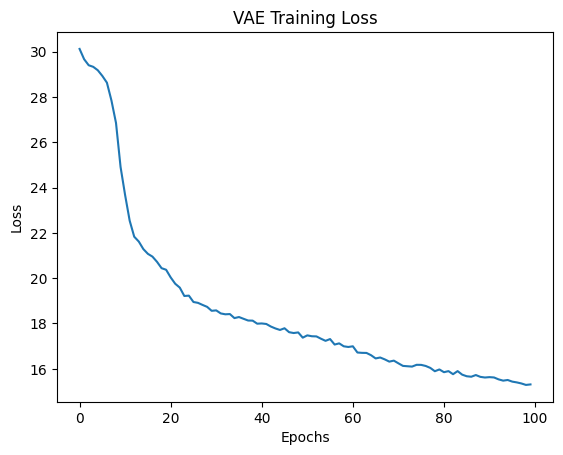

In [10]:
#plot the loss curve
plt.plot(losses)
plt.title("VAE Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


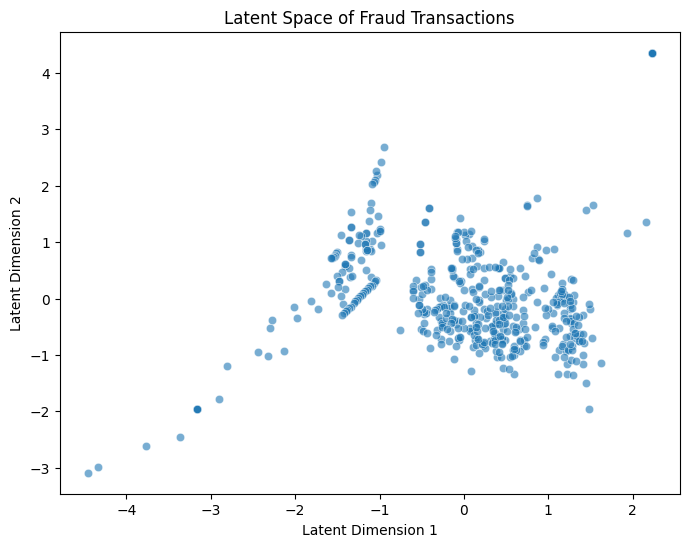

In [11]:
# latent space visualize
vae.eval()
with torch.no_grad():
    _, mu, _ = vae(X_tensor)

mu = mu.numpy()
plt.figure(figsize=(8,6))
sns.scatterplot(x=mu[:,0], y=mu[:,1], alpha=0.6)
plt.title("Latent Space of Fraud Transactions")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.show()


In [12]:
with torch.no_grad():
    z = torch.randn(500, latent_dim)  # Sample from normal distribution
    synthetic_data = vae.decoder(z).numpy()

# Inverse transform to original scale
synthetic_data_original = scaler.inverse_transform(synthetic_data)

# Saving to CSV
synthetic_df = pd.DataFrame(synthetic_data_original, columns=X.columns)
synthetic_df.to_csv("synthetic_fraud.csv", index=False)

print("Synthetic fraud data saved as 'synthetic_fraud.csv'")


Synthetic fraud data saved as 'synthetic_fraud.csv'


In [13]:
# save model weights
torch.save(vae.state_dict(), "vae_model.pth")
print("Model saved as 'vae_model.pth'")


Model saved as 'vae_model.pth'


In [14]:
df = pd.read_csv('synthetic_fraud.csv')
df.head()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-0.370620,0.151463,-1.501350,2.277035,0.288987,-0.659801,-0.417715,0.426046,-0.610026,-1.483154,...,0.201866,-0.188239,0.162232,-0.209640,-0.069678,-0.043053,-0.094302,0.073626,0.046957,185.68867
1,-3.037413,2.522530,-4.335319,3.575875,-2.535583,-1.296525,-2.566669,1.177636,-1.901832,-4.880037,...,0.318469,1.120939,0.162218,-0.253535,-0.071101,-0.088967,-0.039228,0.620122,0.108232,175.53539
2,-6.854757,4.906961,-9.525432,5.674844,-6.088308,-1.961707,-7.666941,2.892196,-3.633871,-8.199860,...,0.521838,1.159136,0.069310,-0.147438,-0.086823,0.067642,0.004978,0.567138,0.061731,119.69620
3,-6.721021,5.318625,-10.609306,6.626404,-5.786261,-2.585561,-8.256277,4.351171,-4.058479,-9.048629,...,0.450667,1.168741,0.018708,-0.323722,-0.146772,0.112325,0.218441,0.806419,0.102462,101.21894
4,-3.335206,2.832546,-5.198175,4.037555,-2.683028,-1.481645,-3.352133,1.452898,-2.247645,-5.330621,...,0.353075,1.017616,0.142391,-0.237859,-0.097702,-0.021088,0.015970,0.599995,0.122825,159.26270
